In [1]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import generate_muap

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from simulators import simulator_biomime7

In [5]:
num_dim = 7
prior = utils.BoxUniform(low=0.5 * torch.ones(num_dim), high=torch.ones(num_dim))

In [ ]:
# Other methods are "SNLE" or "SNRE".
posterior = infer(simulator_biomime7, prior, method="SNPE", num_simulations=100000)

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

 Training neural network. Epochs trained: 164

In [ ]:
with open("biomim7_100k_easy.pkl", "wb") as f:
    pickle.dump(posterior, f)

In [9]:
from scipy.stats import qmc

# LHS sampling from biomime 7
# Generate a large sample of parameters in 6d
n = 1000

np.random.seed(42)
sampler = qmc.LatinHypercube(d=7)
sample = sampler.random(n)
sample = sample/2 + 0.5

lhs_muaps = np.zeros((n, 10, 32, 96))
for i in range(n):
    lhs_muaps[i] = np.reshape(simulator_biomime7(torch.tensor(sample[i])), (10, 32, 96))

# Sample a narrower space to get a better picture
# Repeat for different regions of the space
# sample = sample/8 + 0.75 # Centered around 0.75 +/- 0.125

In [16]:
pars = [0.65, 0.65, 0.7, 0.85, 0.6, 0.85, 0.7]
observation = simulator_biomime7(torch.tensor(pars))

In [17]:
samples = posterior.sample((1000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

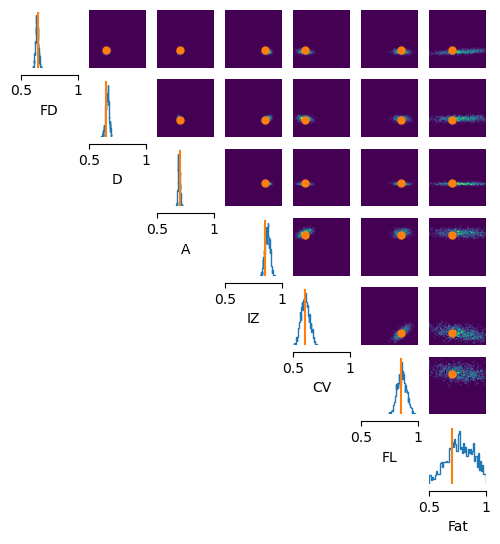

In [18]:
fig, ax = analysis.pairplot(
    samples, 
    limits=[[0.5, 1] for _ in range(7)], 
    figsize=(6, 6),
    points=torch.tensor(pars),
    labels=('FD', 'D', 'A', 'IZ', 'CV', 'FL', 'Fat'),
)

In [ ]:
def get_credible_intervals(samples):
    n_dims = samples.shape[-1]
    interval = np.zeros((n_dims, 2))
    for i in range(n_dims):
        interval[i] = np.percentile(samples[:, i], q=[2.5, 97.5])
        
    return interval.T

In [ ]:
maps = []
cis = []
for par in params:
    observation_pars = torch.from_numpy(par)
    observation = simulator(observation_pars)
    samples = posterior.sample((1000,), x=observation, show_progress_bars=False)
    log_probability = posterior.log_prob(samples, x=observation)
    maps.append(samples[np.argmax(log_probability)])
    cis.append(get_credible_intervals(samples))

In [ ]:
maps = np.array(maps)
cis = np.array(cis)

In [ ]:
with h5py.File('./lhs1000_npe.h5', 'w') as f:
    f.create_dataset('true_muaps', data=muaps)
    f.create_dataset('true_params', data=params)
    f.create_dataset('MAP_estimates', data=maps)
    f.create_dataset('conf_intervals', data=cis)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
titles = ['FD', 'D', 'A', 'IZ', 'CV', 'FL']

for i in range(6):
    col, row = divmod(i, 2)
    errors = np.abs(cis[:, :, i].T-maps[:, i])
    axes[row, col].errorbar(params[:, i], maps[:, i], yerr=errors, fmt='o', linewidth=0.75, ms=2)
    axes[row, col].set_ylim([0.5, 1])
    axes[row, col].set_title(titles[i])

plt.tight_layout()
sns.despine()
plt.show()

### SNPE 

In [ ]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

In [ ]:
# 2 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 5

# The specific observation we want to focus the inference on.
true_par = torch.from_numpy(params[12])
x_obs = simulator(true_par)
prior = utils.BoxUniform(low=0.5 * torch.ones(num_dim), high=torch.ones(num_dim))

posteriors = []
inference = SNPE(prior=prior)
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(
        simulator, 
        proposal, 
        num_simulations=2000, 
        simulation_batch_size=1,
    )

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_obs)

In [ ]:
samples = posterior.sample((10000,), x=x_obs)
log_probability = posterior.log_prob(samples, x=x_obs)
fig, ax = analysis.pairplot(
    samples, 
    limits=[[0.5, 1] for _ in range(6)], 
    figsize=(6, 6),
    points=true_par,
    labels=('FD', 'D', 'A', 'IZ', 'CV', 'FL'),
)

In [ ]:
def run_snle(simulator, x_obs, proposal_prior, rounds=5, sim_budget=10000):
    
    return posterior

### SMC-ABC

In [ ]:
# Use existing SMC-ABC implementation instead of the pyABC impl.
from sbi.inference import prepare_for_sbi, simulate_for_sbi, SMCABC

simulator, prior = prepare_for_sbi(simulator, prior)

In [ ]:
inference = SMCABC(simulator, prior, show_progress_bars=False)

In [ ]:
observation = torch.zeros(3)

In [ ]:
posterior, summary = inference(
    x_o=observation,
    num_particles=50,
    num_initial_pop=100,
    num_simulations=100000,
    epsilon_decay=0.1,
    kde=True,
    return_summary=True,
)

In [ ]:
samples = posterior.sample((1000,))
log_probability = posterior.log_prob(samples)
_ = analysis.pairplot(samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6))